## (Mini-Project): Topic 2.E. (Expressivity and rank of the observable)
### DHRUV BHATNAGAR
### Student, MSc Applied Physics, TU Delft
### TU Delft student number: 5119804

### Imports and preliminaries

In [1]:
import cirq

import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt

In [2]:
np.random.seed(131)
simulator = cirq.Simulator()

### Define useful functions

In [3]:
def qml_encoding_circuit(ftr_vec):
    # takes as input the feature vector and returns a generator for encoding circuit
    # Ry-Rz-Ry pattern with reused features
    yield (cirq.ops.ry(ftr_vec[j]).on(qubit_register[j]) for j in range(n_qubits))
    yield (cirq.ops.rz(ftr_vec[j]).on(qubit_register[j]) for j in range(n_qubits))
    yield (cirq.ops.ry(ftr_vec[j]).on(qubit_register[j]) for j in range(n_qubits))

In [4]:
def qml_data_generation_circuit(ftr_vec):
    # returns the data encoding (data generation) quantum circuit
    # using the generator returned by qml_encoding_circuit
    return cirq.Circuit(qml_encoding_circuit(ftr_vec))

In [5]:
def dataset_generation(data_size, high_rank_obs):
    # helper function to repeatedly call qml_data_generation_circuit
    # to generate a dataset of required size
    x = np.zeros([data_size,n_qubits])
    labels = np.zeros(data_size)
    exp_val = np.zeros(data_size) + np.zeros(data_size)*1.0j
    
    for i in range(data_size):
        # Create random parameters for circuit
        x[i] = np.random.uniform(-1*np.pi, np.pi, size=n_qubits)
        
        # Create circuit
        data_gen_ckt = qml_data_generation_circuit(x[i])
        
        # Simulate the resulting statevector
        result = simulator.simulate(data_gen_ckt)
        
        # Calculate expectation value < psi | O | psi >
        exp_val[i] = np.matmul(np.conj(np.array(result.final_state_vector).T),np.matmul(high_rank_obs,np.array(result.final_state_vector)))

    # Assign labels: +1 if expectation value is greater than 0 (the ideal expectation value for ZZZ...observable), else -1
    for i in range(data_size):
        if(np.real(exp_val[i]) > 0):
            labels[i] = 1
        else:
            labels[i] = -1
    
    # Return dataset
    return x, labels

In [6]:
def qml_variational_circuit(params, architecture_type):
    # returns a generator for the variational circuit which has trainable parameters, given by params argument
    # The function has another argument, architecture_type, which is an integer to select one out of 
    # three implemented variational circuit architectures
    
    if(architecture_type == 1):
        # Variational layers of Rx and linearly-connected Cz
        for l in range(n_layers):
            yield (cirq.ops.rx(params[j + (l * n_qubits)]).on(qubit_register[j]) for j in range(n_qubits))
            yield (cirq.ops.CZ(qubit_register[j],qubit_register[j+1]) for j in range(n_qubits-1))
    elif(architecture_type == 2):
        # Variational layers of Rx, Rz and linearly connected CX
        for l in range(n_layers):
            yield (cirq.ops.rx(params[j + (l * n_qubits)]).on(qubit_register[j]) for j in range(n_qubits))
            yield (cirq.ops.rz(params[j + 2*(l * n_qubits)]).on(qubit_register[j]) for j in range(n_qubits))            
            yield (cirq.ops.CZ(qubit_register[j],qubit_register[j+1]) for j in range(n_qubits-1))
    elif(architecture_type == 3):
        # Variational layers of Rx, Rz, then all possible CX, followed by Rx, Rz
        for l in range(n_layers):
            yield (cirq.ops.rx(params[j + (l * n_qubits)]).on(qubit_register[j]) for j in range(n_qubits))
            yield (cirq.ops.rz(params[j + 2*(l * n_qubits)]).on(qubit_register[j]) for j in range(n_qubits))            

            for j in range(n_qubits):
                for k in range(n_qubits):
                    if j != k:
                        yield (cirq.ops.CX(qubit_register[j],qubit_register[k]))
            
            yield (cirq.ops.rx(params[j + 3*(l * n_qubits)]).on(qubit_register[j]) for j in range(n_qubits))
            yield (cirq.ops.rz(params[j + 4*(l * n_qubits)]).on(qubit_register[j]) for j in range(n_qubits))


In [7]:
def qml_classifier_circuit(ftr_vec, params, variational_architecture=1):
    #  takes the generators of encoding circuit and variational circuit
    # to construct a Cirq quantum circuit to be used as a classifier.
    
    return cirq.Circuit(qml_encoding_circuit(ftr_vec), qml_variational_circuit(params, variational_architecture))

In [8]:
def classifier_predictions(ftr_vec_frame, params, variational_architecture, low_rank_obs):
    # takes as input the frame of feature vectors and constructs the specified type of
    # classifier circuit. The parameters and the low-cost observable are also specified
    # as arguments. This function simulates the required circuits, and returns the
    # predicted labels for the input feature vectors.
    
    data_size = ftr_vec_frame.shape[0]
    exp_val = np.zeros(data_size) + np.zeros(data_size)*1.0j
    predicted_labels = np.zeros(data_size)
    
    for i in range(data_size):
        classifier_ckt = qml_classifier_circuit(ftr_vec_frame[i,:], params, variational_architecture)
        result = simulator.simulate(classifier_ckt)
        exp_val[i] = np.matmul(np.conj(np.array(result.final_state_vector).T),
                               np.matmul(low_rank_obs,np.array(result.final_state_vector)))
        
        # exp_val are in range (0,1) because of eigenvalues of low-rank observables (projectors)
        # whereas, target labels are either -1 or 1
        # so, map exp_val to a range (-1,1). Here, I do this by transforming exp_val -> 2*exp_val - 1
        # would like to use this value as predicted label, so that optimization results in 
        # this predicted value becoming as close as possible to target label
        if(np.real(2*exp_val[i]-1) > 0):
            predicted_labels[i] = 1
        else:
            predicted_labels[i] = -1
            
    return predicted_labels

In [9]:
def training_loss(params, low_rank_obs, variational_architecture, x_train, y_train, x_test, y_test):
    # calculates the cost on both the training set and the test set for analysis
    # (normalized by number of data points)
    
    predicted_labels_training = classifier_predictions(x_train, params, variational_architecture, low_rank_obs)
    cost = np.sum(1-np.multiply(y_train, predicted_labels_training))/y_train.shape[0]
    
    training_cost_tracker.append(cost)
    
    predicted_labels_test = classifier_predictions(x_test, params, variational_architecture, low_rank_obs)
    test_cost_tracker.append(np.sum(1-np.multiply(y_test, predicted_labels_test))/y_test.shape[0])
    
    return cost

### Visualize circuits

In [10]:
# Visualize data generation circuit
n_qubits = 4
qubit_register = cirq.LineQubit.range(n_qubits)
# n_layers = 6
# n_params = n_qubits * n_layers
training_cost_tracker = []
test_cost_tracker = []

data_ckt = qml_data_generation_circuit(np.random.uniform(-1*np.pi, np.pi, size=n_qubits))
print(data_ckt.to_text_diagram(transpose=False))

0: ───Ry(0.3π)──────Rz(0.3π)──────Ry(0.3π)──────

1: ───Ry(0.896π)────Rz(0.896π)────Ry(0.896π)────

2: ───Ry(-0.224π)───Rz(-0.224π)───Ry(-0.224π)───

3: ───Ry(0.283π)────Rz(0.283π)────Ry(0.283π)────


In [11]:
# Visualize classifier with variational architecture 1 - 2 layers
qubit_register = cirq.LineQubit.range(n_qubits)
n_layers = 2
n_params = n_qubits * n_layers
cls_ckt = qml_classifier_circuit(np.random.uniform(-1*np.pi, np.pi, size=2*n_qubits), np.random.uniform(-1*np.pi, np.pi, size=n_params), 1)
print(cls_ckt.to_text_diagram(transpose=True))

0           1           2           3
│           │           │           │
Ry(0.381π)  Ry(-0.747π) Ry(-0.521π) Ry(-0.492π)
│           │           │           │
Rz(0.381π)  Rz(-0.747π) Rz(-0.521π) Rz(-0.492π)
│           │           │           │
Ry(0.381π)  Ry(-0.747π) Ry(-0.521π) Ry(-0.492π)
│           │           │           │
Rx(-0.477π) Rx(-0.893π) Rx(-0.126π) Rx(-0.582π)
│           │           │           │
@───────────@           │           │
│           │           │           │
Rx(0.189π)  @───────────@           │
│           │           │           │
│           Rx(-0.802π) @───────────@
│           │           │           │
@───────────@           Rx(-0.552π) Rx(0.169π)
│           │           │           │
│           @───────────@           │
│           │           │           │
│           │           @───────────@
│           │           │           │


In [12]:
# Visualize classifier with variational architecture 2 - 2 layers
qubit_register = cirq.LineQubit.range(n_qubits)
n_layers = 2
n_params = n_qubits * n_layers
cls_ckt = qml_classifier_circuit(np.random.uniform(-1*np.pi, np.pi, size=2*n_qubits), np.random.uniform(-1*np.pi, np.pi, size=2*n_params), 2)
print(cls_ckt.to_text_diagram(transpose=True))

0          1           2           3
│          │           │           │
Ry(0.918π) Ry(-0.58π)  Ry(0.323π)  Ry(0.005π)
│          │           │           │
Rz(0.918π) Rz(-0.58π)  Rz(0.323π)  Rz(0.005π)
│          │           │           │
Ry(0.918π) Ry(-0.58π)  Ry(0.323π)  Ry(0.005π)
│          │           │           │
Rx(0.086π) Rx(-0.537π) Rx(0.207π)  Rx(-0.647π)
│          │           │           │
Rz(0.086π) Rz(-0.537π) Rz(0.207π)  Rz(-0.647π)
│          │           │           │
@──────────@           │           │
│          │           │           │
Rx(0.773π) @───────────@           │
│          │           │           │
Rz(0.576π) Rx(0.178π)  @───────────@
│          │           │           │
│          Rz(-0.735π) Rx(0.442π)  Rx(-0.449π)
│          │           │           │
@──────────@           Rz(-0.201π) Rz(0.26π)
│          │           │           │
│          @───────────@           │
│          │           │           │
│          │           @───────────@
│         

In [13]:
# Visualize classifier with variational architecture 3 - 1 layers
qubit_register = cirq.LineQubit.range(n_qubits)
n_layers = 1
n_params = n_qubits * n_layers
cls_ckt = qml_classifier_circuit(np.random.uniform(-1*np.pi, np.pi, size=2*n_qubits), np.random.uniform(-1*np.pi, np.pi, size=4*n_params), 3)
print(cls_ckt.to_text_diagram(transpose=True))

  0          1           2          3
  │          │           │          │
  Ry(0.162π) Ry(0.642π)  Ry(0.97π)  Ry(0.869π)
  │          │           │          │
  Rz(0.162π) Rz(0.642π)  Rz(0.97π)  Rz(0.869π)
  │          │           │          │
  Ry(0.162π) Ry(0.642π)  Ry(0.97π)  Ry(0.869π)
  │          │           │          │
  Rx(0.161π) Rx(-0.135π) Rx(0.336π) Rx(-0.527π)
  │          │           │          │
  Rz(0.161π) Rz(-0.135π) Rz(0.336π) Rz(-0.527π)
  │          │           │          │
  @──────────X           │          │
  │          │           │          │
  @──────────┼───────────X          │
  │          │           │          │
  @──────────┼───────────┼──────────X
  │          │           │          │
  X──────────@           │          │
  │          │           │          │
  │          @───────────X          │
  │          │           │          │
┌╴│          │           │          │          ╶┐
│ │          @───────────┼──────────X           │
│ X──────────┼───

### Create dataset and split into training and test set

In [14]:
# Generate high rank observable Z \tensor Z \tensor Z ...
high_rank_obs = [1]
for i in range(n_qubits):
    high_rank_obs = np.kron(high_rank_obs, [[1,0],[0,-1]])

# Generate data
qubit_register = cirq.LineQubit.range(n_qubits)
data_x, data_y = dataset_generation(300, high_rank_obs)
print("Feature vector array shape = ", data_x.shape)
print("Label array shape = ", data_y.shape)
print("Number of points with label -1 = ", (data_y == -1).sum(), "\nNumber of points with label 1 = ", (data_y == 1).sum())

np.savetxt('data_x.csv', data_x, delimiter=",")
np.savetxt('data_y.csv', data_y, delimiter=",")

Feature vector array shape =  (300, 4)
Label array shape =  (300,)
Number of points with label -1 =  131 
Number of points with label 1 =  169


In [15]:
# 80:20 Train:Test split, for preliminary training
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, random_state=42, stratify=data_y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
np.savetxt('x_train.csv', x_train, delimiter=",")
np.savetxt('y_train.csv', y_train, delimiter=",")
np.savetxt('x_test.csv', x_test, delimiter=",")
np.savetxt('y_test.csv', y_test, delimiter=",")

(240, 4) (60, 4) (240,) (60,)


### Create low rank observables of different rank

In [16]:
# Generate low rank observable of different ranks from 1 to full_rank-1
# Rank 1 observable is taken as |0..00><0..00|, rank 2 as |0..00><0..00| + |0..01><0..01|,
# rank 3 as |0..00><0..00| + |0..01><0..01| + |0..10><0..10| etc
# rank 1 observable is stored in index 0, rank 2 in index 1 etc
low_rank_obs = []
for i in range(2**n_qubits-1):
    low_rank_obs.append(np.zeros([2**n_qubits,2**n_qubits]) + np.zeros([2**n_qubits,2**n_qubits])*1.0j)
    for j in range(i+1):
        low_rank_obs[i][j][j] = 1

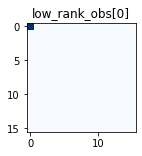

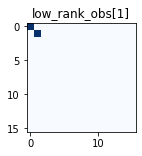

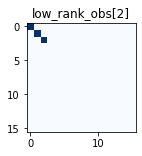

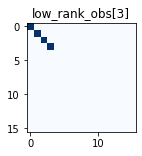

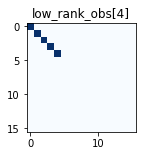

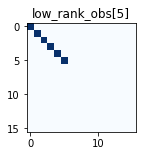

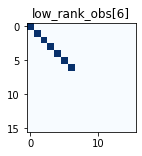

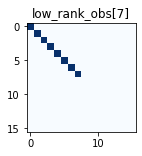

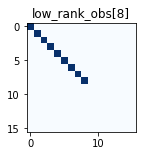

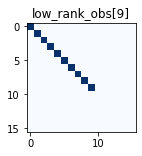

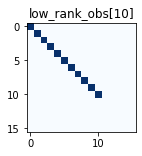

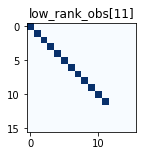

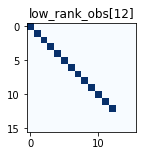

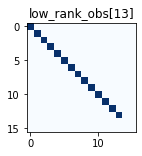

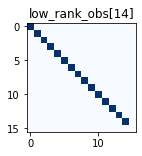

In [17]:
# Visualize the low-rank observables, dark square means there is a 1 in that entry
for i in range(len(low_rank_obs)):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(np.real(low_rank_obs[i]), cmap='Blues', interpolation='nearest')
    plt.title("low_rank_obs["+str(i)+"]")
    plt.show()

### 80:20 Training: Train classifier with variational architecture 1 taking different low-rank observables and number of layers
#### Train classifiers belonging to architecture 1 with different layers and observable ranks and track performance

###########################################################################
Optimization completed for variational architecture 1, number of layers =  2 observable rank =  2
     fun: 0.675
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 80
  status: 1
 success: True
       x: array([-2.25154769, -2.99221394, -4.84551807, -2.24321399,  3.69149944,
        3.18301963,  5.05409826, -4.64878685])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


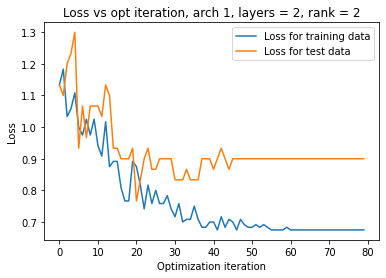

Accuracy on training set =  0.6625
Accuracy on test set =  0.55


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 1, number of layers =  2 observable rank =  4
     fun: 1.125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 50
  status: 1
 success: True
       x: array([-2.54514861, -1.00899337, -0.64159901,  0.53303503, -0.58410134,
        0.49769744,  1.83764862, -6.22381332])


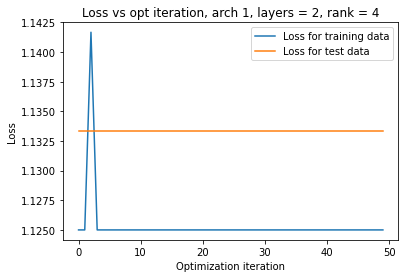

Accuracy on training set =  0.4375
Accuracy on test set =  0.43333333333333335
###########################################################################
Optimization completed for variational architecture 1, number of layers =  2 observable rank =  6
     fun: 0.7166666666666667
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 63
  status: 1
 success: True
       x: array([-2.41844252,  3.0875842 ,  0.59710314,  4.81206276,  4.1956984 ,
       -1.35204558,  0.15756134, -4.29611082])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


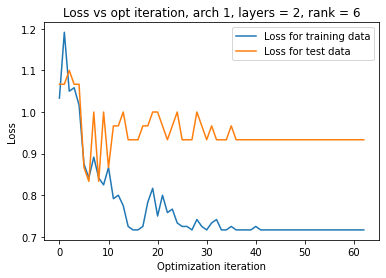

Accuracy on training set =  0.6416666666666667
Accuracy on test set =  0.5333333333333333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 1, number of layers =  2 observable rank =  8
     fun: 0.7666666666666667
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 68
  status: 1
 success: True
       x: array([ 2.90208182e+00,  5.32366580e+00,  3.38201527e+00, -4.00602014e+00,
       -3.25286538e+00,  3.02143119e-04,  6.15342698e+00, -3.45845810e+00])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


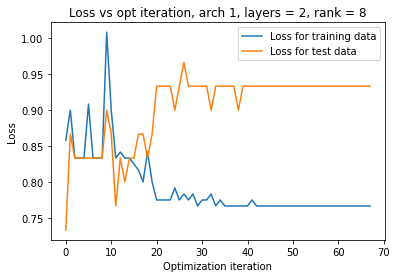

Accuracy on training set =  0.6166666666666667
Accuracy on test set =  0.5333333333333333
###########################################################################
Optimization completed for variational architecture 1, number of layers =  2 observable rank =  10
     fun: 0.7166666666666667
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 74
  status: 1
 success: True
       x: array([ 5.93656731,  5.28751354, -5.32815533, -6.02455051, -6.75810762,
       -2.85694915,  4.46353059, -3.82043229])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


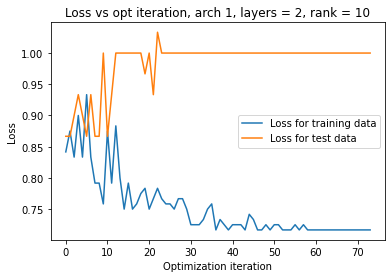

Accuracy on training set =  0.6416666666666667
Accuracy on test set =  0.5
###########################################################################
Optimization completed for variational architecture 1, number of layers =  2 observable rank =  12
     fun: 0.7083333333333334
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 75
  status: 1
 success: True
       x: array([ 4.08620034, -6.0968796 ,  4.7378395 ,  0.35909355, -4.40223211,
       -3.33058286, -5.0108722 , -1.38859649])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


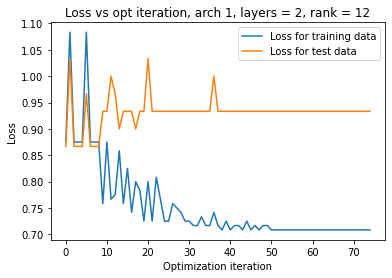

Accuracy on training set =  0.6458333333333334
Accuracy on test set =  0.5333333333333333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 1, number of layers =  2 observable rank =  14
     fun: 0.7583333333333333
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 64
  status: 1
 success: True
       x: array([-2.12807131, -5.9266352 , -2.29021531, -0.13864184,  0.14660056,
        3.10967791, -4.62452616, -0.20391724])


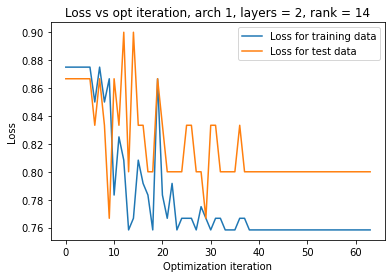

Accuracy on training set =  0.6208333333333333
Accuracy on test set =  0.6


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 1, number of layers =  4 observable rank =  2
     fun: 1.125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 97
  status: 1
 success: True
       x: array([-1.78736297,  5.66400692, -5.91786733,  2.20932441,  4.05155058,
        5.17039422,  3.43810067, -0.73488731, -4.66109241,  1.18102395,
       -1.51884058,  3.22886866,  3.27711754,  1.65646277, -4.41451764,
        4.95587955])


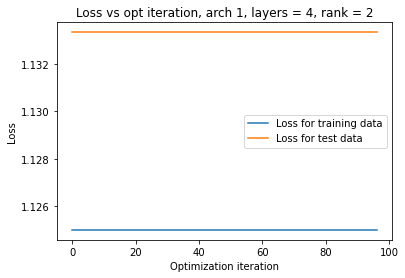

Accuracy on training set =  0.4375
Accuracy on test set =  0.43333333333333335
###########################################################################
Optimization completed for variational architecture 1, number of layers =  4 observable rank =  4
     fun: 1.0083333333333333
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 139
  status: 1
 success: True
       x: array([-3.27485729, -0.34157125,  2.93253848, -3.92728681, -2.31983765,
        0.06077749, -5.04706581,  3.11734257, -2.10541462,  0.781514  ,
        6.21470554,  0.9444151 ,  1.73872164,  2.80064208,  1.97390678,
        5.17451546])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


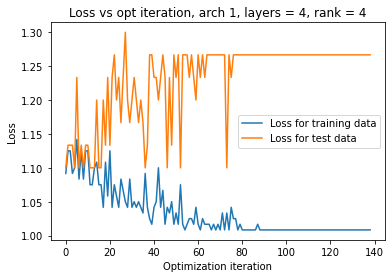

Accuracy on training set =  0.49583333333333335
Accuracy on test set =  0.36666666666666664


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 1, number of layers =  4 observable rank =  6
     fun: 0.6833333333333333
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 140
  status: 1
 success: True
       x: array([ 0.91408569, -2.09553199, -6.18123331, -1.973412  , -2.08551831,
       -0.0449104 , -3.85893982, -2.56084923, -0.71809029,  3.72928438,
        4.33353662, -2.79210814, -2.08656554, -4.94607221, -4.60272165,
       -4.5650329 ])


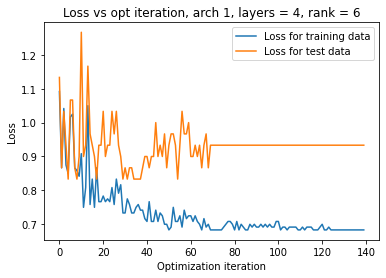

Accuracy on training set =  0.6583333333333333
Accuracy on test set =  0.5333333333333333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 1, number of layers =  4 observable rank =  8
     fun: 0.7416666666666667
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 122
  status: 1
 success: True
       x: array([-2.17190345, -2.17591689, -3.50298077, -3.09575011,  1.13219303,
        2.57036288,  2.34488537, -3.06804922, -5.81938175, -4.01757586,
        1.26699322, -4.78410932,  3.77828399, -4.86863985,  5.62592202,
        2.20067288])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


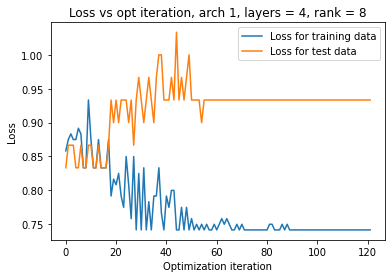

Accuracy on training set =  0.6291666666666667
Accuracy on test set =  0.5333333333333333
###########################################################################
Optimization completed for variational architecture 1, number of layers =  4 observable rank =  10
     fun: 0.875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 97
  status: 1
 success: True
       x: array([ 1.52763029, -3.24677355, -1.73160978, -0.93506095,  4.34788085,
        3.92221451,  0.71060674, -2.42194533, -2.34659095,  5.95609837,
       -1.45326789, -2.46640954, -1.08188342,  0.34365692,  2.93208792,
       -3.77629922])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


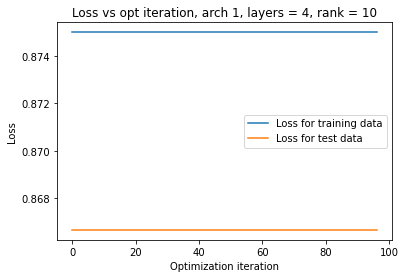

Accuracy on training set =  0.5625
Accuracy on test set =  0.5666666666666667
###########################################################################
Optimization completed for variational architecture 1, number of layers =  4 observable rank =  12
     fun: 0.7666666666666667
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 123
  status: 1
 success: True
       x: array([-5.61849172, -4.75717176, -0.17064578, -3.800907  , -1.78561087,
       -1.62035375,  1.32644201,  5.4558003 , -1.82127807, -0.77011286,
        2.18207054, -0.40316308,  4.13426844, -4.99895348,  6.14497767,
        2.93292848])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


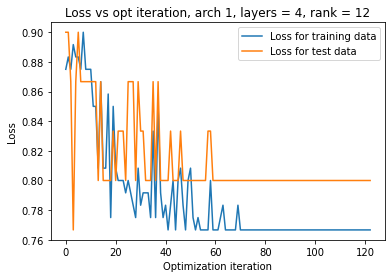

Accuracy on training set =  0.6166666666666667
Accuracy on test set =  0.6


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 1, number of layers =  4 observable rank =  14
     fun: 0.7583333333333333
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 130
  status: 1
 success: True
       x: array([-4.10414875, -4.66617232,  4.46947823, -3.24588639,  0.71713354,
        0.12517035, -0.35813887, -3.65447008,  1.29843189, -0.18419721,
        4.1803857 ,  3.4196746 ,  5.72016615,  1.67571806, -3.56460844,
       -4.65010859])


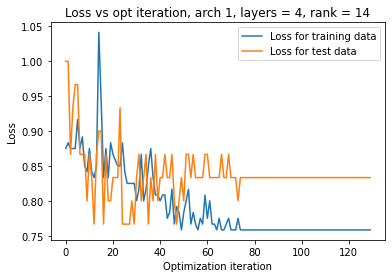

Accuracy on training set =  0.6208333333333333
Accuracy on test set =  0.5833333333333334


In [18]:
# These quantities don't change throughout training
variational_architecture = 1
n_qubits = 4

# These hold quantities which are varied for training different classifiers
ranks = [2,4,6,8,10,12,14]
layers = [2,4]

# Variable to store accuracy values
training_accuracies_arch1 = np.zeros([len(ranks),len(layers)])
test_accuracies_arch1 = np.zeros([len(ranks),len(layers)])

final_params_arch1 = {}

for l_idx in range(len(layers)):
    for r_idx in range(len(ranks)):
        # Define/initialize useful variables
        n_layers = layers[l_idx]
        n_params = n_qubits * n_layers
        training_cost_tracker = []
        test_cost_tracker = []
        qubit_register = cirq.LineQubit.range(n_qubits)
        
        dict_key = 'layers_'+str(n_layers)+'_rank_'+str(ranks[r_idx])
        
        # Optimize loss with respect to parameters
        final_params_arch1[dict_key] = minimize(training_loss,
                                                x0 = np.random.uniform(-2*np.pi, 2*np.pi, size=n_params),
                                                args = (low_rank_obs[ranks[r_idx]-1],
                                                        variational_architecture,
                                                        x_train,
                                                        y_train,
                                                        x_test,
                                                        y_test),
                                                method="COBYLA",
                                                options={"maxiter":250})
        
        # Optimization is complete
        print("###########################################################################")
        print("Optimization completed for variational architecture 1, number of layers = ", n_layers, "observable rank = ", ranks[r_idx])
        print(final_params_arch1[dict_key])
        
        # Figures of training cost and test cost versus training iteration
        plt.plot(list(range(len(training_cost_tracker))), training_cost_tracker)
        plt.plot(list(range(len(test_cost_tracker))), test_cost_tracker)
        plt.legend(['Loss for training data','Loss for test data'])
        plt.title('Loss vs opt iteration, arch 1, layers = '+str(n_layers)+', rank = '+str(ranks[r_idx]))
        plt.xlabel('Optimization iteration')
        plt.ylabel('Loss')
        plt.savefig('loss_arch_1_layers_'+str(n_layers)+'_rank_'+str(ranks[r_idx]))
        plt.savefig('loss_arch_1_layers_'+str(n_layers)+'_rank_'+str(ranks[r_idx])+'.eps', format='eps',dpi=1200)
        plt.show()
        
        # Accuracy values
        training_acc = accuracy_score(y_train,classifier_predictions(x_train, final_params_arch1[dict_key].x, variational_architecture, low_rank_obs[ranks[r_idx]-1]))
        test_acc = accuracy_score(y_test,classifier_predictions(x_test, final_params_arch1[dict_key].x, variational_architecture, low_rank_obs[ranks[r_idx]-1]))
        print("Accuracy on training set = ", training_acc)
        print("Accuracy on test set = ", test_acc)
        training_accuracies_arch1[r_idx][l_idx] = training_acc
        test_accuracies_arch1[r_idx][l_idx] = test_acc        


In [19]:
with open('final_params_arch1.txt','w') as data: 
      data.write(str(final_params_arch1))

In [20]:
print(training_accuracies_arch1)
print(test_accuracies_arch1)
np.savetxt('training_accuracies_arch1.csv', training_accuracies_arch1, delimiter=",")
np.savetxt('test_accuracies_arch1.csv', test_accuracies_arch1, delimiter=",")

[[0.6625     0.4375    ]
 [0.4375     0.49583333]
 [0.64166667 0.65833333]
 [0.61666667 0.62916667]
 [0.64166667 0.5625    ]
 [0.64583333 0.61666667]
 [0.62083333 0.62083333]]
[[0.55       0.43333333]
 [0.43333333 0.36666667]
 [0.53333333 0.53333333]
 [0.53333333 0.53333333]
 [0.5        0.56666667]
 [0.53333333 0.6       ]
 [0.6        0.58333333]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


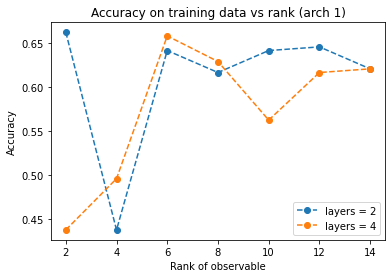

In [21]:
for l_idx in range(len(layers)):
    plt.plot(ranks, [training_accuracies_arch1[0][l_idx],
                     training_accuracies_arch1[1][l_idx],
                     training_accuracies_arch1[2][l_idx],
                     training_accuracies_arch1[3][l_idx],
                     training_accuracies_arch1[4][l_idx],
                     training_accuracies_arch1[5][l_idx],
                     training_accuracies_arch1[6][l_idx]],
             'o--')

plt.legend(['layers = '+str(layers[0]),'layers = '+str(layers[1])])
plt.title('Accuracy on training data vs rank (arch 1)')
plt.xlabel('Rank of observable')
plt.ylabel('Accuracy')
plt.savefig('training_acc_vs_rank_arch1.png')
plt.savefig('training_acc_vs_rank_arch1.eps', format='eps', dpi=1200)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


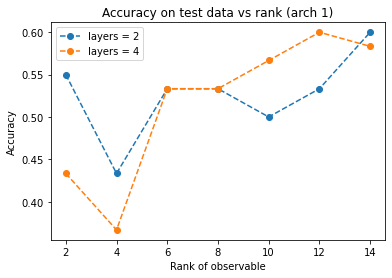

In [22]:
for l_idx in range(len(layers)):
    plt.plot(ranks, [test_accuracies_arch1[0][l_idx],
                     test_accuracies_arch1[1][l_idx],
                     test_accuracies_arch1[2][l_idx],
                     test_accuracies_arch1[3][l_idx],
                     test_accuracies_arch1[4][l_idx],
                     test_accuracies_arch1[5][l_idx],
                     test_accuracies_arch1[6][l_idx]],
             'o--')

plt.legend(['layers = '+str(layers[0]),'layers = '+str(layers[1])])
plt.title('Accuracy on test data vs rank (arch 1)')
plt.xlabel('Rank of observable')
plt.ylabel('Accuracy')
plt.savefig('test_acc_vs_rank_arch1.png')
plt.savefig('test_acc_vs_rank_arch1.eps', format='eps', dpi=1200)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


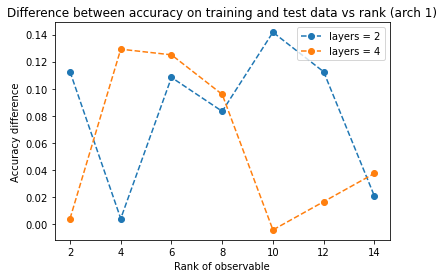

In [23]:
# Difference between training accuracy and test accuracy as function of rank
for l_idx in range(len(layers)):
    plt.plot(ranks, [training_accuracies_arch1[0][l_idx] - test_accuracies_arch1[0][l_idx],
                     training_accuracies_arch1[1][l_idx] - test_accuracies_arch1[1][l_idx],
                     training_accuracies_arch1[2][l_idx] - test_accuracies_arch1[2][l_idx],
                     training_accuracies_arch1[3][l_idx] - test_accuracies_arch1[3][l_idx],
                     training_accuracies_arch1[4][l_idx] - test_accuracies_arch1[4][l_idx],
                     training_accuracies_arch1[5][l_idx] - test_accuracies_arch1[5][l_idx],
                     training_accuracies_arch1[6][l_idx] - test_accuracies_arch1[6][l_idx]],
             'o--')

plt.legend(['layers = '+str(layers[0]),'layers = '+str(layers[1])])
plt.title('Difference between accuracy on training and test data vs rank (arch 1)')
plt.xlabel('Rank of observable')
plt.ylabel('Accuracy difference')
plt.savefig('diff_acc_vs_rank_arch1.png')
plt.savefig('diff_acc_vs_rank_arch1.eps', format='eps', dpi=1200)

plt.show()

### 80:20 Training: Train classifier with variational architecture 2 taking different low-rank observables and number of layers
#### Train classifiers belonging to architecture 2 with different layers and observable ranks and track performance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 2, number of layers =  2 observable rank =  2
     fun: 1.125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 98
  status: 1
 success: True
       x: array([-2.38294821,  3.45693064,  2.80267327,  4.07624003, -0.82161002,
        4.51731354,  3.00910739,  4.98688698, -5.46547954, -3.29418567,
       -1.81801054,  0.45519388,  3.87349456, -3.56259964,  2.84988924,
       -3.58570714])


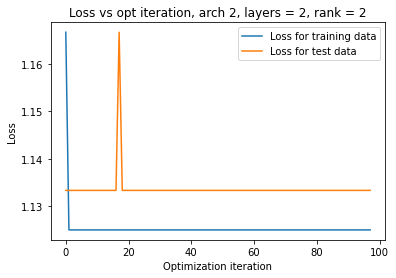

Accuracy on training set =  0.4375
Accuracy on test set =  0.43333333333333335


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 2, number of layers =  2 observable rank =  4
     fun: 1.125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 98
  status: 1
 success: True
       x: array([ 1.03088906, -2.90286126, -3.91354509, -4.32840019,  4.11844709,
        5.342151  , -2.92562558,  5.37675567, -5.53650641,  3.77193957,
       -1.26627846, -5.15723307, -4.07982802,  2.85616159,  2.7262113 ,
       -2.43987239])


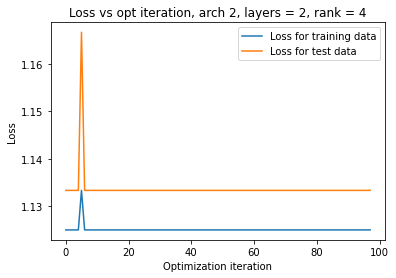

Accuracy on training set =  0.4375
Accuracy on test set =  0.43333333333333335
###########################################################################
Optimization completed for variational architecture 2, number of layers =  2 observable rank =  6
     fun: 0.775
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 135
  status: 1
 success: True
       x: array([ 0.04956355, -5.18728045, -2.30411436, -3.61100845,  6.23505578,
        0.01913351, -2.20539166,  1.27039462,  3.59981164, -3.37001706,
        1.87363179, -1.75870864, -2.26354844, -5.69762568, -3.71877648,
        2.37032081])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


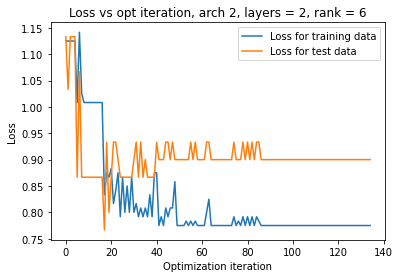

Accuracy on training set =  0.6125
Accuracy on test set =  0.55
###########################################################################
Optimization completed for variational architecture 2, number of layers =  2 observable rank =  8
     fun: 0.875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 113
  status: 1
 success: True
       x: array([-3.15841635, -5.2565695 ,  0.99955745, -4.98688379,  1.58308545,
       -2.38431353, -0.22102442, -5.82032662,  0.61635078,  4.93460309,
       -4.96885794, -4.24602232, -5.26071411,  4.64536641,  0.30880173,
        3.76422726])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


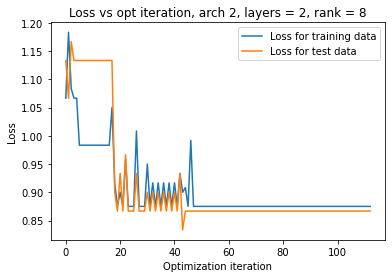

Accuracy on training set =  0.5625
Accuracy on test set =  0.5666666666666667
###########################################################################
Optimization completed for variational architecture 2, number of layers =  2 observable rank =  10
     fun: 0.8
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 143
  status: 1
 success: True
       x: array([-0.64229288,  0.3048254 ,  4.15206301, -2.30614093, -5.87948952,
       -2.80774488,  6.72655767,  5.39630426,  5.95368795, -4.02523454,
        5.84516552, -2.25699468,  4.92859378, -4.30712154,  0.53181603,
       -1.93870769])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


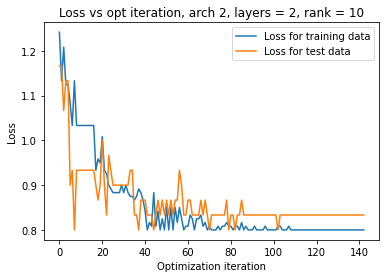

Accuracy on training set =  0.6
Accuracy on test set =  0.5833333333333334


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 2, number of layers =  2 observable rank =  12
     fun: 0.7583333333333333
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 147
  status: 1
 success: True
       x: array([ 2.64075724, -1.27719767, -5.19600406,  1.82860234, -5.29070367,
        4.80889774,  2.90786127, -5.00385538, -3.02396369,  5.05168122,
        0.87262924, -1.22291021,  5.10099078, -4.35461863, -2.00046636,
        5.8556797 ])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


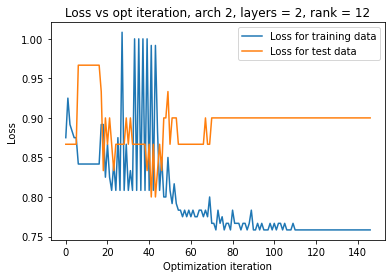

Accuracy on training set =  0.6208333333333333
Accuracy on test set =  0.55
###########################################################################
Optimization completed for variational architecture 2, number of layers =  2 observable rank =  14
     fun: 0.875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 97
  status: 1
 success: True
       x: array([ 0.39742501,  4.44370128,  6.2041299 ,  4.38153537, -5.86415474,
       -1.26986806, -0.14906162,  2.88620541,  5.11506228,  3.10886131,
       -0.76095904, -5.84406506, -3.80738225, -4.90089777,  0.96475762,
        5.82047949])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


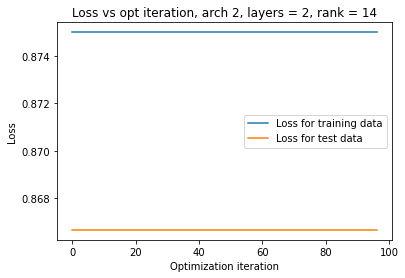

Accuracy on training set =  0.5625
Accuracy on test set =  0.5666666666666667
###########################################################################
Optimization completed for variational architecture 2, number of layers =  4 observable rank =  2
     fun: 1.125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 193
  status: 1
 success: True
       x: array([ 5.57022624, -2.46553399,  2.55355745, -5.18192822, -1.74896057,
        2.10844903,  6.1861602 , -6.23724679, -6.05376216,  5.24647171,
       -0.62878911, -2.72646648,  5.85374867,  2.79768602, -2.68122333,
       -1.83244365,  4.77453651, -0.74372869,  3.42509071, -1.22718286,
       -4.31205573,  5.0743489 ,  2.09314079,  1.18030462,  1.74493373,
        3.95632837,  0.70415756, -1.36957422,  0.2223636 ,  0.28742883,
       -4.61550264,  0.91155158])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


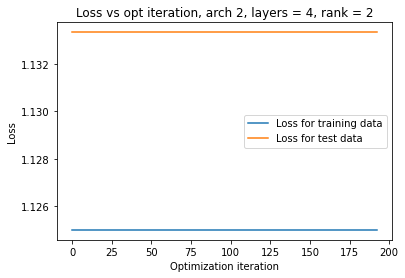

Accuracy on training set =  0.4375
Accuracy on test set =  0.43333333333333335
###########################################################################
Optimization completed for variational architecture 2, number of layers =  4 observable rank =  4
     fun: 0.75
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 250
  status: 2
 success: False
       x: array([-0.74321704,  0.36906009, -3.34292048, -4.82079098,  4.96993069,
       -1.27967241,  0.40174949, -4.0811436 ,  2.40410705, -3.8133707 ,
       -3.54591577,  0.38588568, -0.92556054,  4.39950435, -4.6598113 ,
       -0.25628378, -2.14123077, -3.46859996, -6.10000486, -2.14304795,
        5.83923962,  0.15560421,  4.01573064,  0.55860577, -4.37479019,
       -5.7737687 , -3.33548432, -5.59491591,  4.9728304 , -1.29835856,
        2.88617822,  0.54232676])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


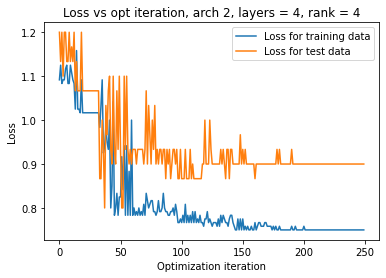

Accuracy on training set =  0.625
Accuracy on test set =  0.55
###########################################################################
Optimization completed for variational architecture 2, number of layers =  4 observable rank =  6
     fun: 0.775
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 250
  status: 2
 success: False
       x: array([-0.72538456, -5.8634718 ,  3.93124118,  5.90709347,  5.85574522,
        5.1691281 ,  0.67846494,  3.72879851, -4.94629188, -2.04128156,
       -1.79955756, -0.82344449,  0.66405813,  4.0999108 , -4.52791882,
       -5.24690543, -1.41300884, -4.46713371, -1.44004706, -1.78454759,
        2.2903096 , -4.556419  , -1.56317003, -1.91601556,  1.23372631,
        2.58295437, -4.32820988, -5.7720193 ,  4.90554431, -0.51727023,
        1.96350217,  2.76863848])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


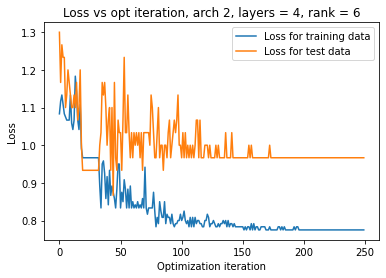

Accuracy on training set =  0.6125
Accuracy on test set =  0.5166666666666667
###########################################################################
Optimization completed for variational architecture 2, number of layers =  4 observable rank =  8
     fun: 0.7
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 250
  status: 2
 success: False
       x: array([ 3.78037471,  0.73820343,  2.76661711, -0.55664549,  5.93965772,
        2.42318726,  3.19951073,  0.02976371, -5.05332589, -5.96896087,
       -5.87430048,  5.70388869, -1.75501896,  6.29732641, -1.29200009,
        4.67887818, -1.21836421, -2.1390725 ,  3.91589868, -0.31179788,
       -5.33490858,  2.52785953,  5.58713755,  4.1037293 , -3.40371741,
        4.44227626, -1.77538137, -1.45596862,  4.09356672,  5.72503288,
        6.22430913,  5.88810907])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


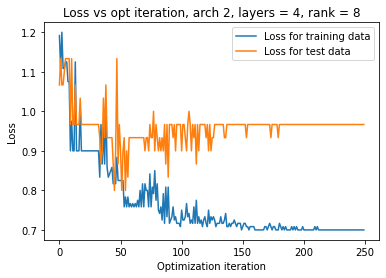

Accuracy on training set =  0.65
Accuracy on test set =  0.5166666666666667
###########################################################################
Optimization completed for variational architecture 2, number of layers =  4 observable rank =  10
     fun: 0.8166666666666667
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 250
  status: 2
 success: False
       x: array([ 1.32857647,  0.13531388, -1.04905601, -3.33793518, -4.29997068,
       -3.33522395, -5.13280103,  1.99807363, -3.78492184, -4.77984829,
        3.62208387, -1.06324472,  2.88816053,  6.18632548,  1.31319819,
        2.24496515,  3.91829391, -3.99864856, -1.99211915, -0.10330107,
       -3.50554801, -0.26574142,  0.39228776,  2.66557739, -0.45146814,
       -5.31335181,  5.14079236, -4.41250486, -5.70205754, -2.13721706,
        1.31061961, -1.35152539])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


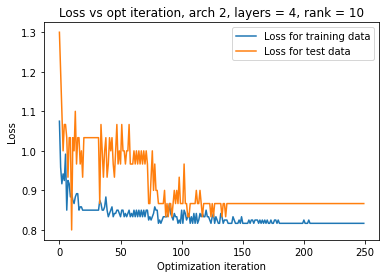

Accuracy on training set =  0.5916666666666667
Accuracy on test set =  0.5666666666666667
###########################################################################
Optimization completed for variational architecture 2, number of layers =  4 observable rank =  12
     fun: 0.8583333333333333
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 212
  status: 1
 success: True
       x: array([-3.71218939, -2.07600794, -3.35549567,  5.76712276, -2.068558  ,
        5.23329303,  2.92234381,  0.97605551,  0.14215049, -1.54635275,
        4.65690928,  0.48146969,  5.08791196,  6.0990672 , -1.27294002,
        2.77018462, -3.53305079, -2.57631737, -5.05830774, -2.31258696,
        5.10400809, -5.19772983, -4.86038329, -0.66259569, -5.13483095,
       -3.4230472 ,  4.49906784, -1.42787747, -3.11471853,  2.96701487,
        0.2234098 , -4.83291429])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


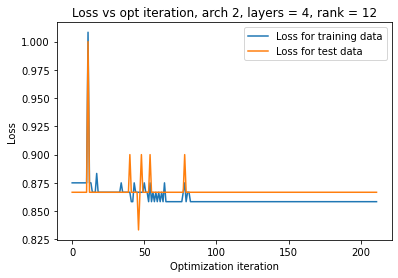

Accuracy on training set =  0.5708333333333333
Accuracy on test set =  0.5666666666666667
###########################################################################
Optimization completed for variational architecture 2, number of layers =  4 observable rank =  14
     fun: 0.7833333333333333
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 250
  status: 2
 success: False
       x: array([-4.37621432,  3.46233093, -4.36495467, -1.05846759,  1.0428031 ,
       -0.51586066,  6.04054577,  2.65486415, -3.191348  , -2.52033026,
       -1.54653801, -2.07771016, -6.18414843, -3.40641951,  5.8170079 ,
        4.19772717,  2.63466781,  1.52589451, -1.61554695,  2.48351265,
       -3.28725549,  3.22429057, -0.854169  , -3.68557063,  4.10382767,
       -3.29517622,  2.39355426, -1.09619529,  2.44688307, -2.20936871,
        0.49165204, -1.13079426])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


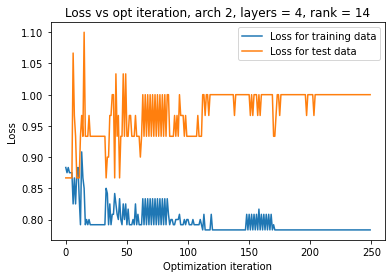

Accuracy on training set =  0.6083333333333333
Accuracy on test set =  0.5


In [24]:
# These quantities don't change throughout training
variational_architecture = 2
n_qubits = 4

# These hold quantities which are varied for training different classifiers
ranks = [2,4,6,8,10,12,14]
layers = [2,4]

# Variable to store accuracy values
training_accuracies_arch2 = np.zeros([len(ranks),len(layers)])
test_accuracies_arch2 = np.zeros([len(ranks),len(layers)])

final_params_arch2 = {}

for l_idx in range(len(layers)):
    for r_idx in range(len(ranks)):
        # Define/initialize useful variables
        n_layers = layers[l_idx]
        n_params = n_qubits * n_layers
        training_cost_tracker = []
        test_cost_tracker = []
        qubit_register = cirq.LineQubit.range(n_qubits)
        
        dict_key = 'layers_'+str(n_layers)+'_rank_'+str(ranks[r_idx])
        
        # Optimize loss with respect to parameters
        final_params_arch2[dict_key] = minimize(training_loss,
                                                x0 = np.random.uniform(-2*np.pi, 2*np.pi, size=2*n_params),
                                                args = (low_rank_obs[ranks[r_idx]-1],
                                                        variational_architecture,
                                                        x_train,
                                                        y_train,
                                                        x_test,
                                                        y_test),
                                                method="COBYLA",
                                                options={"maxiter":250})
        
        # Optimization is complete
        print("###########################################################################")
        print("Optimization completed for variational architecture 2, number of layers = ", n_layers, "observable rank = ", ranks[r_idx])
        print(final_params_arch2[dict_key])
        
        # Figures of training cost and test cost versus training iteration
        plt.plot(list(range(len(training_cost_tracker))), training_cost_tracker)
        plt.plot(list(range(len(test_cost_tracker))), test_cost_tracker)
        plt.legend(['Loss for training data','Loss for test data'])
        plt.title('Loss vs opt iteration, arch 2, layers = '+str(n_layers)+', rank = '+str(ranks[r_idx]))
        plt.xlabel('Optimization iteration')
        plt.ylabel('Loss')
        plt.savefig('loss_arch_2_layers_'+str(n_layers)+'_rank_'+str(ranks[r_idx]))
        plt.savefig('loss_arch_2_layers_'+str(n_layers)+'_rank_'+str(ranks[r_idx])+'.eps', format='eps',dpi=1200)
        plt.show()
        
        # Accuracy values
        training_acc = accuracy_score(y_train,classifier_predictions(x_train, final_params_arch2[dict_key].x, variational_architecture, low_rank_obs[ranks[r_idx]-1]))
        test_acc = accuracy_score(y_test,classifier_predictions(x_test, final_params_arch2[dict_key].x, variational_architecture, low_rank_obs[ranks[r_idx]-1]))
        print("Accuracy on training set = ", training_acc)
        print("Accuracy on test set = ", test_acc)
        training_accuracies_arch2[r_idx][l_idx] = training_acc
        test_accuracies_arch2[r_idx][l_idx] = test_acc 

In [25]:
with open('final_params_arch2.txt','w') as data: 
      data.write(str(final_params_arch2))

In [26]:
print(training_accuracies_arch2)
print(test_accuracies_arch2)
np.savetxt('training_accuracies_arch2.csv', training_accuracies_arch2, delimiter=",")
np.savetxt('test_accuracies_arch2.csv', test_accuracies_arch2, delimiter=",")

[[0.4375     0.4375    ]
 [0.4375     0.625     ]
 [0.6125     0.6125    ]
 [0.5625     0.65      ]
 [0.6        0.59166667]
 [0.62083333 0.57083333]
 [0.5625     0.60833333]]
[[0.43333333 0.43333333]
 [0.43333333 0.55      ]
 [0.55       0.51666667]
 [0.56666667 0.51666667]
 [0.58333333 0.56666667]
 [0.55       0.56666667]
 [0.56666667 0.5       ]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


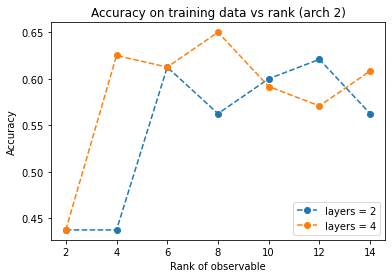

In [27]:
for l_idx in range(len(layers)):
    plt.plot(ranks, [training_accuracies_arch2[0][l_idx],
                     training_accuracies_arch2[1][l_idx],
                     training_accuracies_arch2[2][l_idx],
                     training_accuracies_arch2[3][l_idx],
                     training_accuracies_arch2[4][l_idx],
                     training_accuracies_arch2[5][l_idx],
                     training_accuracies_arch2[6][l_idx]],
             'o--')

plt.legend(['layers = '+str(layers[0]),'layers = '+str(layers[1])])
plt.title('Accuracy on training data vs rank (arch 2)')
plt.xlabel('Rank of observable')
plt.ylabel('Accuracy')
plt.savefig('training_acc_vs_rank_arch2.png')
plt.savefig('training_acc_vs_rank_arch2.eps', format='eps', dpi=1200)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


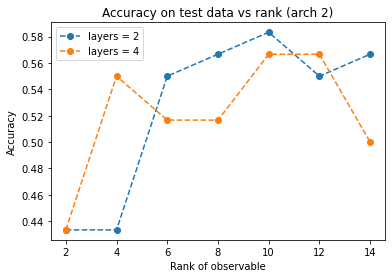

In [28]:
for l_idx in range(len(layers)):
    plt.plot(ranks, [test_accuracies_arch2[0][l_idx],
                     test_accuracies_arch2[1][l_idx],
                     test_accuracies_arch2[2][l_idx],
                     test_accuracies_arch2[3][l_idx],
                     test_accuracies_arch2[4][l_idx],
                     test_accuracies_arch2[5][l_idx],
                     test_accuracies_arch2[6][l_idx]],
             'o--')

plt.legend(['layers = '+str(layers[0]),'layers = '+str(layers[1])])
plt.title('Accuracy on test data vs rank (arch 2)')
plt.xlabel('Rank of observable')
plt.ylabel('Accuracy')
plt.savefig('test_acc_vs_rank_arch2.png')
plt.savefig('test_acc_vs_rank_arch2.eps', format='eps', dpi=1200)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


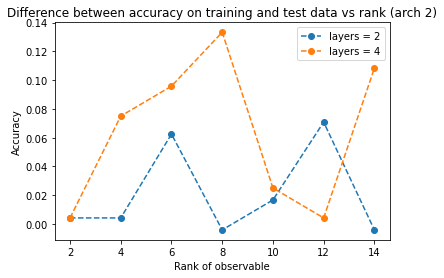

In [29]:
# Difference between training accuracy and test accuracy as function of rank
for l_idx in range(len(layers)):
    plt.plot(ranks, [training_accuracies_arch2[0][l_idx] - test_accuracies_arch2[0][l_idx],
                     training_accuracies_arch2[1][l_idx] - test_accuracies_arch2[1][l_idx],
                     training_accuracies_arch2[2][l_idx] - test_accuracies_arch2[2][l_idx],
                     training_accuracies_arch2[3][l_idx] - test_accuracies_arch2[3][l_idx],
                     training_accuracies_arch2[4][l_idx] - test_accuracies_arch2[4][l_idx],
                     training_accuracies_arch2[5][l_idx] - test_accuracies_arch2[5][l_idx],
                     training_accuracies_arch2[6][l_idx] - test_accuracies_arch2[6][l_idx]],
             'o--')

plt.legend(['layers = '+str(layers[0]),'layers = '+str(layers[1])])
plt.title('Difference between accuracy on training and test data vs rank (arch 2)')
plt.xlabel('Rank of observable')
plt.ylabel('Accuracy')
plt.savefig('diff_acc_vs_rank_arch2.png')
plt.savefig('diff_acc_vs_rank_arch2.eps', format='eps', dpi=1200)

plt.show()

### 80:20 Training: Train classifier with variational architecture 3 taking different low-rank observables
#### Train classifiers belonging to architecture 3 with different observable ranks and track performance

###########################################################################
Optimization completed for variational architecture 3, number of layers =  2 observable rank =  2
     fun: 1.125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 193
  status: 1
 success: True
       x: array([-1.89122047, -2.75983366, -1.01592026, -1.75956537,  2.68194706,
        0.0190241 ,  3.77333981, -4.03951304, -2.87657293, -2.87169694,
       -4.00754147, -3.87943077,  4.01602214, -2.98452404,  2.94123846,
       -0.90063284, -1.48382045,  3.80757809,  1.87111966, -0.5016518 ,
        0.05427162,  0.09793686,  0.99745782, -0.40137706, -5.98429043,
       -5.87824093, -4.45675638, -4.0497445 , -0.25303709,  5.31227546,
       -3.14116501,  3.9081327 ])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


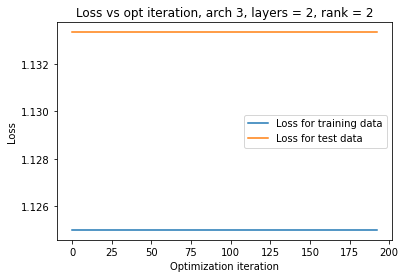

Accuracy on training set =  0.4375
Accuracy on test set =  0.43333333333333335
###########################################################################
Optimization completed for variational architecture 3, number of layers =  2 observable rank =  4
     fun: 0.7166666666666667
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 250
  status: 2
 success: False
       x: array([ 0.54753811,  1.11415642, -3.98181213, -4.86162658, -5.64083421,
       -5.16563088,  2.56518743, -2.58363323, -4.0560867 , -4.88729715,
        2.61551797,  1.18286945, -2.57189327, -1.50119393,  5.30092754,
       -2.36912637,  3.06536437,  3.35626818, -3.92524515, -0.99350953,
        4.34314122,  3.19031088, -5.72549608, -3.95628477, -3.80490496,
        2.90383887,  4.83199447,  4.66923825, -6.21231648,  3.95422842,
       -5.89911542, -1.1612622 ])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


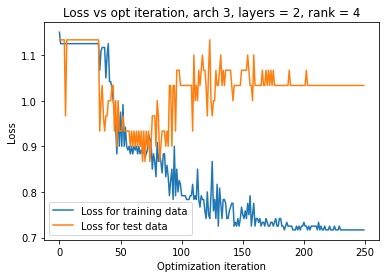

Accuracy on training set =  0.6416666666666667
Accuracy on test set =  0.48333333333333334
###########################################################################
Optimization completed for variational architecture 3, number of layers =  2 observable rank =  6
     fun: 0.7583333333333333
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 250
  status: 2
 success: False
       x: array([ 2.27562199,  6.27787266, -3.91739913, -4.19997663,  4.93029956,
       -1.70326334, -0.17794292,  1.27469648,  4.43631892,  4.56125424,
       -4.8550703 , -1.58900846,  5.23440607, -2.14361563,  4.2938996 ,
        5.48797626,  3.39241374, -5.89491748,  3.69436939,  5.87951031,
        2.80008256, -4.76567448,  0.3619178 ,  4.73306103, -4.70121769,
        4.26624524,  5.97255675,  5.04209269,  5.33895284,  5.8253894 ,
        3.35095292,  6.18188194])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


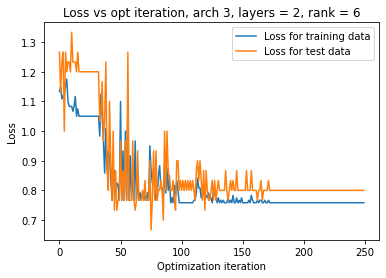

Accuracy on training set =  0.6208333333333333
Accuracy on test set =  0.6


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 3, number of layers =  2 observable rank =  8
     fun: 0.7666666666666667
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 250
  status: 2
 success: False
       x: array([ 1.06697071,  3.62416883, -3.98972613,  0.64651788,  1.93270582,
        5.74270956, -2.42640071,  2.25358688, -2.24257237, -0.24027618,
       -0.24150728,  6.11911107, -5.16464205,  0.24249778, -4.30711836,
        5.78607403, -6.15563168, -2.41338838,  1.48462508,  5.83287235,
       -2.76849043,  4.98986612, -2.20153959,  0.11550257, -0.94851041,
        4.43530805, -0.47618191,  3.33339261, -4.51141565,  3.08306685,
       -5.76528261,  2.79970141])


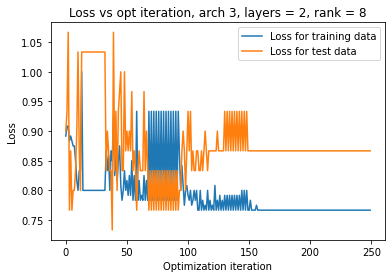

Accuracy on training set =  0.6166666666666667
Accuracy on test set =  0.5666666666666667
###########################################################################
Optimization completed for variational architecture 3, number of layers =  2 observable rank =  10
     fun: 0.8333333333333334
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 250
  status: 2
 success: False
       x: array([ 5.29743218e+00,  3.92685350e+00, -2.24031514e-03, -2.13274368e+00,
        5.46869026e+00,  1.76255939e-01,  1.61457972e+00, -6.18713402e-01,
       -6.01121068e+00, -8.66081887e-01,  3.21091681e+00,  8.99240738e-02,
        5.62946671e+00,  3.15030016e+00,  6.18722050e+00, -1.58265869e+00,
        2.65531521e+00, -3.88071482e+00,  1.12792441e+00,  2.58458845e+00,
        2.37278755e+00, -4.78866225e+00, -5.48543655e+00, -1.34823762e+00,
        5.64449114e+00, -3.97769910e+00, -1.58594374e+00,  1.71405225e+00,
       -4.70167916e+00, -5.66939531e+00,  4.3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


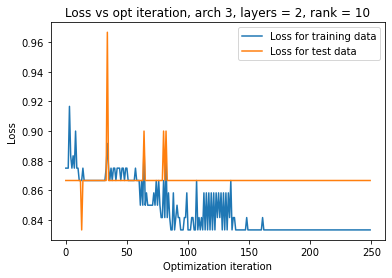

Accuracy on training set =  0.5833333333333334
Accuracy on test set =  0.5666666666666667


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 3, number of layers =  2 observable rank =  12
     fun: 0.85
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 219
  status: 1
 success: True
       x: array([ 4.74343399,  1.13698922, -4.84587428,  3.81539115,  3.7365305 ,
       -1.50259783, -1.84303772, -0.8983713 , -3.2507228 ,  4.18901299,
        1.82621452,  1.35969091, -3.57154141, -2.07992176, -2.40686999,
        4.65042563, -5.50136277,  3.54811961,  5.16558549,  2.9043988 ,
        1.63327725, -2.55537983, -0.42502559, -2.33581534, -4.91246587,
       -0.90119987,  2.62148992,  1.66540372, -2.36520549,  2.90553672,
        3.63271056,  1.42897573])


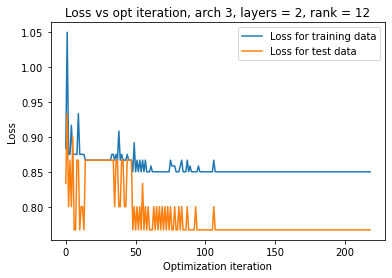

Accuracy on training set =  0.575
Accuracy on test set =  0.6166666666666667


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###########################################################################
Optimization completed for variational architecture 3, number of layers =  2 observable rank =  14
     fun: 0.8083333333333333
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 250
  status: 2
 success: False
       x: array([ 5.41453041, -4.24311323,  5.08993837,  4.34019116, -3.5061457 ,
        2.60851013,  1.69113184,  4.61092383, -3.62203094,  0.76102262,
        1.54461604, -5.73153856,  3.74016312,  2.15802445,  4.13993136,
       -1.47480731, -3.94556282,  5.87059655, -2.24964318,  4.45823012,
       -3.2129452 , -0.36645915,  1.38840517, -4.3891195 ,  5.52282692,
        1.26277299,  4.19117573, -4.52277682, -1.63511587, -1.6120833 ,
       -4.73727633, -4.12701894])


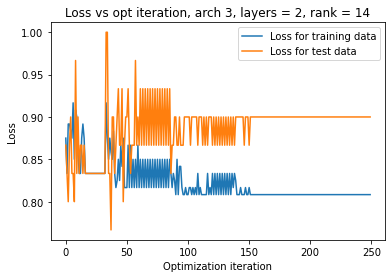

Accuracy on training set =  0.5958333333333333
Accuracy on test set =  0.55


In [30]:
# These quantities don't change throughout training
variational_architecture = 3
n_qubits = 4

# These hold quantities which are varied for training different classifiers
ranks = [2,4,6,8,10,12,14]
layers = [2]

# Variable to store accuracy values
training_accuracies_arch3 = np.zeros([len(ranks),len(layers)])
test_accuracies_arch3 = np.zeros([len(ranks),len(layers)])

final_params_arch3 = {}

for l_idx in range(len(layers)):
    for r_idx in range(len(ranks)):
        # Define/initialize useful variables
        n_layers = layers[l_idx]
        n_params = n_qubits * n_layers
        training_cost_tracker = []
        test_cost_tracker = []
        qubit_register = cirq.LineQubit.range(n_qubits)
        
        dict_key = 'layers_'+str(n_layers)+'_rank_'+str(ranks[r_idx])
        
        # Optimize loss with respect to parameters
        final_params_arch3[dict_key] = minimize(training_loss,
                                                x0 = np.random.uniform(-2*np.pi, 2*np.pi, size=4*n_params),
                                                args = (low_rank_obs[ranks[r_idx]-1],
                                                        variational_architecture,
                                                        x_train,
                                                        y_train,
                                                        x_test,
                                                        y_test),
                                                method="COBYLA",
                                                options={"maxiter":250})
        
        # Optimization is complete
        print("###########################################################################")
        print("Optimization completed for variational architecture 3, number of layers = ", n_layers, "observable rank = ", ranks[r_idx])
        print(final_params_arch3[dict_key])
        
        # Figures of training cost and test cost versus training iteration
        plt.plot(list(range(len(training_cost_tracker))), training_cost_tracker)
        plt.plot(list(range(len(test_cost_tracker))), test_cost_tracker)
        plt.legend(['Loss for training data','Loss for test data'])
        plt.title('Loss vs opt iteration, arch 3, layers = '+str(n_layers)+', rank = '+str(ranks[r_idx]))
        plt.xlabel('Optimization iteration')
        plt.ylabel('Loss')
        plt.savefig('loss_arch_3_layers_'+str(n_layers)+'_rank_'+str(ranks[r_idx]))
        plt.savefig('loss_arch_3_layers_'+str(n_layers)+'_rank_'+str(ranks[r_idx])+'.eps', format='eps',dpi=1200)
        plt.show()
        
        # Accuracy values
        training_acc = accuracy_score(y_train,classifier_predictions(x_train, final_params_arch3[dict_key].x, variational_architecture, low_rank_obs[ranks[r_idx]-1]))
        test_acc = accuracy_score(y_test,classifier_predictions(x_test, final_params_arch3[dict_key].x, variational_architecture, low_rank_obs[ranks[r_idx]-1]))
        print("Accuracy on training set = ", training_acc)
        print("Accuracy on test set = ", test_acc)
        training_accuracies_arch3[r_idx][l_idx] = training_acc
        test_accuracies_arch3[r_idx][l_idx] = test_acc

In [31]:
with open('final_params_arch3.txt','w') as data: 
      data.write(str(final_params_arch3))

In [32]:
print(training_accuracies_arch3)
print(test_accuracies_arch3)
np.savetxt('training_accuracies_arch3.csv', training_accuracies_arch3, delimiter=",")
np.savetxt('test_accuracies_arch3.csv', test_accuracies_arch3, delimiter=",")

[[0.4375    ]
 [0.64166667]
 [0.62083333]
 [0.61666667]
 [0.58333333]
 [0.575     ]
 [0.59583333]]
[[0.43333333]
 [0.48333333]
 [0.6       ]
 [0.56666667]
 [0.56666667]
 [0.61666667]
 [0.55      ]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


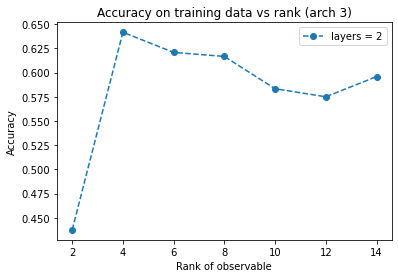

In [33]:
for l_idx in range(len(layers)):
    plt.plot(ranks, [training_accuracies_arch3[0][l_idx],
                     training_accuracies_arch3[1][l_idx],
                     training_accuracies_arch3[2][l_idx],
                     training_accuracies_arch3[3][l_idx],
                     training_accuracies_arch3[4][l_idx],
                     training_accuracies_arch3[5][l_idx],
                     training_accuracies_arch3[6][l_idx]],
             'o--')

plt.legend(['layers = '+str(layers[0])])
plt.title('Accuracy on training data vs rank (arch 3)')
plt.xlabel('Rank of observable')
plt.ylabel('Accuracy')
plt.savefig('training_acc_vs_rank_arch3.png')
plt.savefig('training_acc_vs_rank_arch3.eps', format='eps', dpi=1200)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


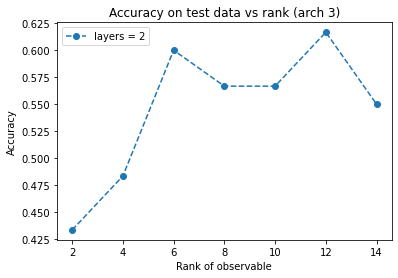

In [34]:
for l_idx in range(len(layers)):
    plt.plot(ranks, [test_accuracies_arch3[0][l_idx],
                     test_accuracies_arch3[1][l_idx],
                     test_accuracies_arch3[2][l_idx],
                     test_accuracies_arch3[3][l_idx],
                     test_accuracies_arch3[4][l_idx],
                     test_accuracies_arch3[5][l_idx],
                     test_accuracies_arch3[6][l_idx]],
             'o--')

plt.legend(['layers = '+str(layers[0])])
plt.title('Accuracy on test data vs rank (arch 3)')
plt.xlabel('Rank of observable')
plt.ylabel('Accuracy')
plt.savefig('test_acc_vs_rank_arch3.png')
plt.savefig('test_acc_vs_rank_arch3.eps', format='eps', dpi=1200)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


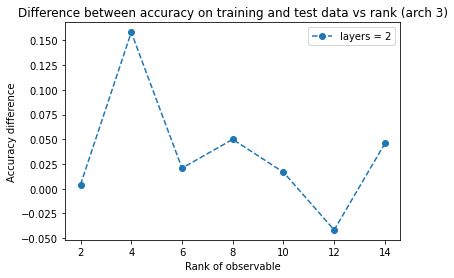

In [35]:
# Difference between training accuracy and test accuracy as function of rank
for l_idx in range(len(layers)):
    plt.plot(ranks, [training_accuracies_arch3[0][l_idx] - test_accuracies_arch3[0][l_idx],
                     training_accuracies_arch3[1][l_idx] - test_accuracies_arch3[1][l_idx],
                     training_accuracies_arch3[2][l_idx] - test_accuracies_arch3[2][l_idx],
                     training_accuracies_arch3[3][l_idx] - test_accuracies_arch3[3][l_idx],
                     training_accuracies_arch3[4][l_idx] - test_accuracies_arch3[4][l_idx],
                     training_accuracies_arch3[5][l_idx] - test_accuracies_arch3[5][l_idx],
                     training_accuracies_arch3[6][l_idx] - test_accuracies_arch3[6][l_idx]],
             'o--')

plt.legend(['layers = '+str(layers[0])])
plt.title('Difference between accuracy on training and test data vs rank (arch 3)')
plt.xlabel('Rank of observable')
plt.ylabel('Accuracy difference')
plt.savefig('diff_acc_vs_rank_arch3.png')
plt.savefig('diff_acc_vs_rank_arch3.eps', format='eps', dpi=1200)

plt.show()

### Comparison among architectures vs rank, 80:20 split training/test, for same number of layers (=2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


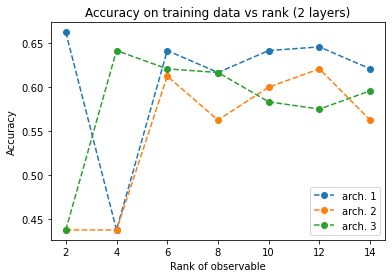

In [36]:
plt.plot(ranks, [training_accuracies_arch1[0][0],
                 training_accuracies_arch1[1][0],
                 training_accuracies_arch1[2][0],
                 training_accuracies_arch1[3][0],
                 training_accuracies_arch1[4][0],
                 training_accuracies_arch1[5][0],
                 training_accuracies_arch1[6][0]],
         'o--')

plt.plot(ranks, [training_accuracies_arch2[0][0],
                 training_accuracies_arch2[1][0],
                 training_accuracies_arch2[2][0],
                 training_accuracies_arch2[3][0],
                 training_accuracies_arch2[4][0],
                 training_accuracies_arch2[5][0],
                 training_accuracies_arch2[6][0]],
         'o--')

plt.plot(ranks, [training_accuracies_arch3[0][0],
                 training_accuracies_arch3[1][0],
                 training_accuracies_arch3[2][0],
                 training_accuracies_arch3[3][0],
                 training_accuracies_arch3[4][0],
                 training_accuracies_arch3[5][0],
                 training_accuracies_arch3[6][0]],
         'o--')

plt.legend(['arch. 1', 'arch. 2', 'arch. 3'])
plt.title('Accuracy on training data vs rank (2 layers)')
plt.xlabel('Rank of observable')
plt.ylabel('Accuracy')
plt.savefig('training_acc_vs_rank_all_arch.png')
plt.savefig('training_acc_vs_rank_all_arch.eps', format='eps', dpi=1200)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


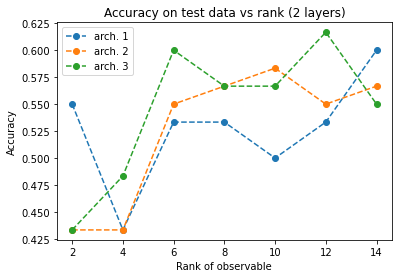

In [37]:
plt.plot(ranks, [test_accuracies_arch1[0][0],
                 test_accuracies_arch1[1][0],
                 test_accuracies_arch1[2][0],
                 test_accuracies_arch1[3][0],
                 test_accuracies_arch1[4][0],
                 test_accuracies_arch1[5][0],
                 test_accuracies_arch1[6][0]],
         'o--')

plt.plot(ranks, [test_accuracies_arch2[0][0],
                 test_accuracies_arch2[1][0],
                 test_accuracies_arch2[2][0],
                 test_accuracies_arch2[3][0],
                 test_accuracies_arch2[4][0],
                 test_accuracies_arch2[5][0],
                 test_accuracies_arch2[6][0]],
         'o--')

plt.plot(ranks, [test_accuracies_arch3[0][0],
                 test_accuracies_arch3[1][0],
                 test_accuracies_arch3[2][0],
                 test_accuracies_arch3[3][0],
                 test_accuracies_arch3[4][0],
                 test_accuracies_arch3[5][0],
                 test_accuracies_arch3[6][0]],
         'o--')

plt.legend(['arch. 1', 'arch. 2', 'arch. 3'])
plt.title('Accuracy on test data vs rank (2 layers)')
plt.xlabel('Rank of observable')
plt.ylabel('Accuracy')
plt.savefig('test_acc_vs_rank_all_arch.png')
plt.savefig('test_acc_vs_rank_all_arch.eps', format='eps', dpi=1200)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


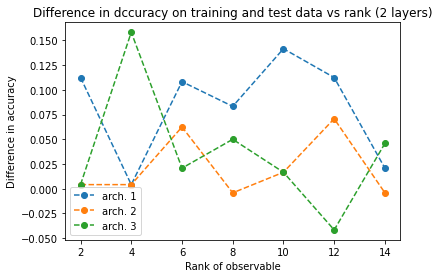

In [38]:
plt.plot(ranks, [training_accuracies_arch1[0][0]-test_accuracies_arch1[0][0],
                 training_accuracies_arch1[1][0]-test_accuracies_arch1[1][0],
                 training_accuracies_arch1[2][0]-test_accuracies_arch1[2][0],
                 training_accuracies_arch1[3][0]-test_accuracies_arch1[3][0],
                 training_accuracies_arch1[4][0]-test_accuracies_arch1[4][0],
                 training_accuracies_arch1[5][0]-test_accuracies_arch1[5][0],
                 training_accuracies_arch1[6][0]-test_accuracies_arch1[6][0]],
         'o--')

plt.plot(ranks, [training_accuracies_arch2[0][0]-test_accuracies_arch2[0][0],
                 training_accuracies_arch2[1][0]-test_accuracies_arch2[1][0],
                 training_accuracies_arch2[2][0]-test_accuracies_arch2[2][0],
                 training_accuracies_arch2[3][0]-test_accuracies_arch2[3][0],
                 training_accuracies_arch2[4][0]-test_accuracies_arch2[4][0],
                 training_accuracies_arch2[5][0]-test_accuracies_arch2[5][0],
                 training_accuracies_arch2[6][0]-test_accuracies_arch2[6][0]],
         'o--')

plt.plot(ranks, [training_accuracies_arch3[0][0]-test_accuracies_arch3[0][0],
                 training_accuracies_arch3[1][0]-test_accuracies_arch3[1][0],
                 training_accuracies_arch3[2][0]-test_accuracies_arch3[2][0],
                 training_accuracies_arch3[3][0]-test_accuracies_arch3[3][0],
                 training_accuracies_arch3[4][0]-test_accuracies_arch3[4][0],
                 training_accuracies_arch3[5][0]-test_accuracies_arch3[5][0],
                 training_accuracies_arch3[6][0]-test_accuracies_arch3[6][0]],
         'o--')

plt.legend(['arch. 1', 'arch. 2', 'arch. 3'])
plt.title('Difference in dccuracy on training and test data vs rank (2 layers)')
plt.xlabel('Rank of observable')
plt.ylabel('Difference in accuracy')
plt.savefig('diff_acc_vs_rank_all_arch.png')
plt.savefig('diff_acc_vs_rank_all_arch.eps', format='eps', dpi=1200)
plt.show()

### k-fold cross validation for classifiers of different ranks and architectures. k=3.
#### This code also compares average accuracy (over folds) for different architectures

In [39]:
# k fold cross validation split
n_splits=3
skf = StratifiedKFold(n_splits=n_splits)
kfold = skf.split(data_x, data_y)

n_qubits = 4

# These hold quantities which are varied for training different classifiers
ranks = [2,4,6,8,10,12,14]
layers = 2

# Variable to store accuracy values
kfold_training_accuracies_arch1 = np.zeros([len(ranks),n_splits])
kfold_test_accuracies_arch1 = np.zeros([len(ranks),n_splits])
kfold_training_accuracies_arch2 = np.zeros([len(ranks),n_splits])
kfold_test_accuracies_arch2 = np.zeros([len(ranks),n_splits])
kfold_training_accuracies_arch3 = np.zeros([len(ranks),n_splits])
kfold_test_accuracies_arch3 = np.zeros([len(ranks),n_splits])

for k, (train, test) in enumerate(kfold):
    for r_idx in range(len(ranks)):
        # Define/initialize useful variables
        n_layers = layers
        n_params = n_qubits * n_layers
        
        # Train classifier with variational architecture 1
        qubit_register = cirq.LineQubit.range(n_qubits)
        final_params = minimize(training_loss,
                                x0 = np.random.uniform(-1*np.pi, np.pi, size=n_params),
                                args = (low_rank_obs[ranks[r_idx]-1],
                                        1,
                                        data_x[train],
                                        data_y[train],
                                        data_x[test],
                                        data_y[test]),
                                method="COBYLA",
                                options={"maxiter":250})

        # Optimization is complete
        print("###########################################################################")
        print("Optimization completed for variational architecture 1, fold = ", k, "observable rank = ", ranks[r_idx])
        print(final_params)

        # Accuracy values
        training_acc = accuracy_score(data_y[train],classifier_predictions(data_x[train], final_params.x, 1, low_rank_obs[ranks[r_idx]-1]))
        test_acc = accuracy_score(data_y[test],classifier_predictions(data_x[test], final_params.x, 1, low_rank_obs[ranks[r_idx]-1]))
        kfold_training_accuracies_arch1[r_idx][k] = training_acc
        kfold_test_accuracies_arch1[r_idx][k] = test_acc
        
        # Train classifier with variational architecture 2
        qubit_register = cirq.LineQubit.range(n_qubits)
        final_params = minimize(training_loss,
                                x0 = np.random.uniform(-1*np.pi, np.pi, size=2*n_params),
                                args = (low_rank_obs[ranks[r_idx]-1],
                                        2,
                                        data_x[train],
                                        data_y[train],
                                        data_x[test],
                                        data_y[test]),
                                method="COBYLA",
                                options={"maxiter":250})

        # Optimization is complete
        print("###########################################################################")
        print("Optimization completed for variational architecture 2, fold = ", k, "observable rank = ", ranks[r_idx])
        print(final_params)

        # Accuracy values
        training_acc = accuracy_score(data_y[train],classifier_predictions(data_x[train], final_params.x, 2, low_rank_obs[ranks[r_idx]-1]))
        test_acc = accuracy_score(data_y[test],classifier_predictions(data_x[test], final_params.x, 2, low_rank_obs[ranks[r_idx]-1]))
        kfold_training_accuracies_arch2[r_idx][k] = training_acc
        kfold_test_accuracies_arch2[r_idx][k] = test_acc
                                               
        # Train classifier with variational architecture 3
        qubit_register = cirq.LineQubit.range(n_qubits)
        final_params = minimize(training_loss,
                                x0 = np.random.uniform(-1*np.pi, np.pi, size=4*n_params),
                                args = (low_rank_obs[ranks[r_idx]-1],
                                        3,
                                        data_x[train],
                                        data_y[train],
                                        data_x[test],
                                        data_y[test]),
                                method="COBYLA",
                                options={"maxiter":250})

        # Optimization is complete
        print("###########################################################################")
        print("Optimization completed for variational architecture 3, fold = ", k, "observable rank = ", ranks[r_idx])
        print(final_params)

        # Accuracy values
        training_acc = accuracy_score(data_y[train],classifier_predictions(data_x[train], final_params.x, 3, low_rank_obs[ranks[r_idx]-1]))
        test_acc = accuracy_score(data_y[test],classifier_predictions(data_x[test], final_params.x, 3, low_rank_obs[ranks[r_idx]-1]))
        kfold_training_accuracies_arch3[r_idx][k] = training_acc
        kfold_test_accuracies_arch3[r_idx][k] = test_acc

###########################################################################
Optimization completed for variational architecture 1, fold =  0 observable rank =  2
     fun: 1.13
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 49
  status: 1
 success: True
       x: array([ 0.32019701, -1.05751524, -1.04088462, -1.82517331, -1.65601402,
       -1.33985831, -0.0172674 ,  2.81167251])
###########################################################################
Optimization completed for variational architecture 2, fold =  0 observable rank =  2
     fun: 0.8
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 139
  status: 1
 success: True
       x: array([-1.87478382,  4.09039248, -2.4521424 , -0.73027726,  2.13483385,
       -2.66215563, -3.81503694,  1.91331545,  1.78247139, -0.08095118,
       -1.54624107, -3.14270823,  2.33886228, -3.14862992, -2.14837433,
       -0.75897911])
##############################################################

In [40]:
np.savetxt('kfold_training_accuracies_arch1.csv', kfold_training_accuracies_arch1, delimiter=",")
np.savetxt('kfold_test_accuracies_arch1.csv', kfold_test_accuracies_arch1, delimiter=",")

np.savetxt('kfold_training_accuracies_arch2.csv', kfold_training_accuracies_arch2, delimiter=",")
np.savetxt('kfold_test_accuracies_arch2.csv', kfold_test_accuracies_arch2, delimiter=",")

np.savetxt('kfold_training_accuracies_arch3.csv', kfold_training_accuracies_arch3, delimiter=",")
np.savetxt('kfold_test_accuracies_arch3.csv', kfold_test_accuracies_arch3, delimiter=",")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


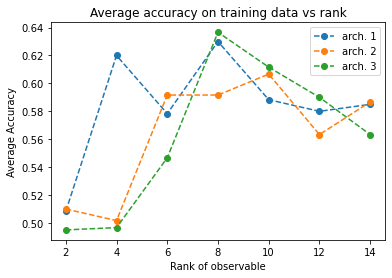

In [41]:
plt.plot(ranks, np.mean(kfold_training_accuracies_arch1,axis=1), 'o--')

plt.plot(ranks, np.mean(kfold_training_accuracies_arch2,axis=1), 'o--')

plt.plot(ranks, np.mean(kfold_training_accuracies_arch3,axis=1), 'o--')


plt.legend(['arch. 1', 'arch. 2', 'arch. 3'])
plt.title('Average accuracy on training data vs rank')
plt.xlabel('Rank of observable')
plt.ylabel('Average Accuracy')
plt.savefig('kfold_avg_training_acc_vs_rank.png')
plt.savefig('kfold_avg_training_acc_vs_rank.eps', format='eps', dpi=1200)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


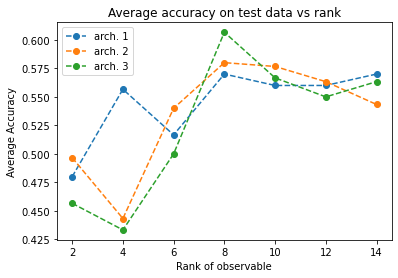

In [42]:
plt.plot(ranks, np.mean(kfold_test_accuracies_arch1,axis=1), 'o--')

plt.plot(ranks, np.mean(kfold_test_accuracies_arch2,axis=1), 'o--')

plt.plot(ranks, np.mean(kfold_test_accuracies_arch3,axis=1), 'o--')


plt.legend(['arch. 1', 'arch. 2', 'arch. 3'])
plt.title('Average accuracy on test data vs rank')
plt.xlabel('Rank of observable')
plt.ylabel('Average Accuracy')
plt.savefig('kfold_avg_test_acc_vs_rank.png')
plt.savefig('kfold_avg_test_acc_vs_rank.eps', format='eps', dpi=1200)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


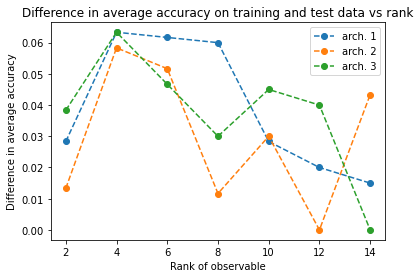

In [43]:
plt.plot(ranks, np.mean(kfold_training_accuracies_arch1,axis=1)-np.mean(kfold_test_accuracies_arch1,axis=1), 'o--')

plt.plot(ranks, np.mean(kfold_training_accuracies_arch2,axis=1)-np.mean(kfold_test_accuracies_arch2,axis=1), 'o--')

plt.plot(ranks, np.mean(kfold_training_accuracies_arch3,axis=1)-np.mean(kfold_test_accuracies_arch3,axis=1), 'o--')


plt.legend(['arch. 1', 'arch. 2', 'arch. 3'])
plt.title('Difference in average accuracy on training and test data vs rank')
plt.xlabel('Rank of observable')
plt.ylabel('Difference in average accuracy')
plt.savefig('kfold_avg_diff_acc_vs_rank.png')
plt.savefig('kfold_avg_diff_acc_vs_rank.eps', format='eps', dpi=1200)
plt.show()

##### End of notebook